In [1]:
#!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg


--2020-12-28 13:55:25--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 2606:4700::6812:14b7, 2606:4700::6812:15b7, 104.18.20.183, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|2606:4700::6812:14b7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211346 (206K) [image/jpeg]
Saving to: 'image.jpg’

image.jpg           100%[===================>] 206,39K  --.-KB/s    in 0,05s   

2020-12-28 13:55:26 (3,87 MB/s) - 'image.jpg’ saved [211346/211346]



In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# Model downloading

In [43]:
# grab the model from Tensorflow hub and append a softmax activation
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build downloaded Model

In [44]:

# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
_________________________________________________________________
activation (Activation)      (None, 1001)              0         
Total params: 23,853,833
Trainable params: 0
Non-trainable params: 23,853,833
_________________________________________________________________


In [20]:
img = cv2.imread('image.jpg')
img.shape

(720, 960, 3)

(720, 960, 3)

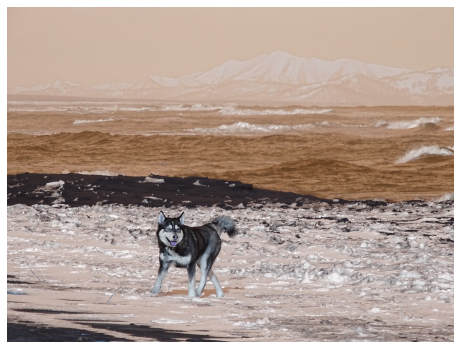

In [25]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off');

In [5]:
type(img)

numpy.ndarray

In [26]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

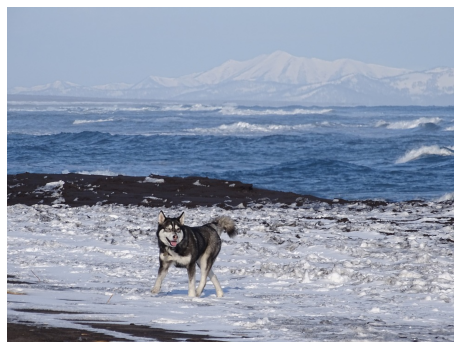

In [27]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off');

In [28]:
image = np.expand_dims(img, axis=0)

image.shape

(1, 720, 960, 3)

In [29]:
# Siberian Husky's class ID in ImageNet
class_index = 251   


In [30]:
# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 1001

In [33]:

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

In [35]:
expected_output.numpy()

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:

class_index*

251

In [38]:

image.shape[0]

1

# Actual working

In [39]:
# read the image
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

In [40]:
# Siberian Husky's class ID in ImageNet
class_index = 251   

# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

In [41]:
image.shape[0]

1

# Compute Gradients

In [46]:
with tf.GradientTape() as tape:
    inputs = tf.cast(image, tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
    loss = tf.keras.losses.categorical_crossentropy(
             expected_output, predictions)
gradients = tape.gradient(loss, inputs)

In [47]:
gradients.shape

TensorShape([1, 300, 300, 3])

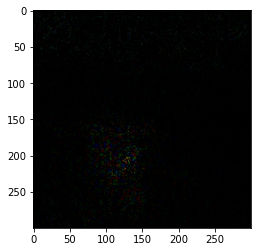

In [49]:
plt.imshow(tf.squeeze(gradients))


In [50]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1) 

In [51]:
grayscale_tensor.shape

TensorShape([1, 300, 300])

In [61]:

grayscale_tensor.numpy()[0].max(), grayscale_tensor.numpy().min()

(1.2167094, 0.0)

In [ ]:
# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.


In [63]:
X = grayscale_tensor
x_min = tf.reduce_min(X)
x_max = tf.reduce_max(X)

In [66]:
normalized_grayscale_tensor = 255 * ((X - x_min) / (x_max - x_min))

In [67]:
normalized_grayscale_tensor = tf.cast(normalized_grayscale_tensor, tf.uint8)

In [69]:
normalized_tensor = tf.squeeze(normalized_grayscale_tensor)

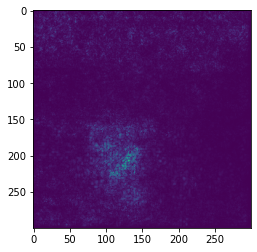

In [70]:
plt.imshow(normalized_tensor)

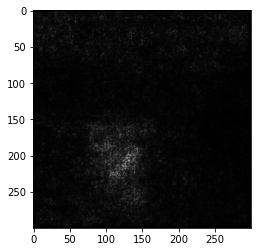

In [72]:
plt.imshow(normalized_tensor, cmap='gray')

# Sanity check

In [71]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

1.2167094
0.0



In [73]:
np.argmax(grayscale_tensor[0])

61029

In [74]:
grayscale_tensor[0].shape

TensorShape([300, 300])

# Maximum value of the gradient is found here

In [79]:
max_pixel_index = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
max_pixel_index

(203, 129)

# Minimum value of the gradient is found here

In [80]:
min_pixel_index =np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel_index 

(0, 299)

In [81]:
normalized_tensor[max_pixel_index]

<tf.Tensor: shape=(), dtype=uint8, numpy=255>

In [82]:
normalized_tensor[min_pixel_index]

<tf.Tensor: shape=(), dtype=uint8, numpy=0>

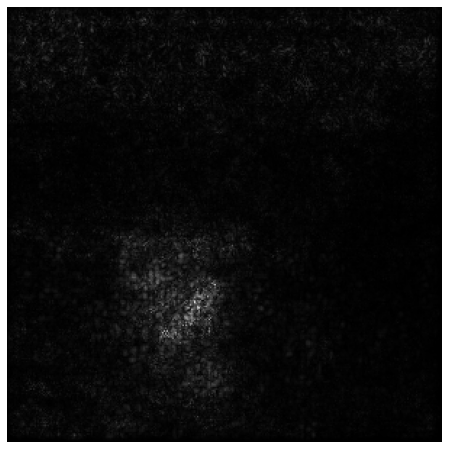

In [83]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

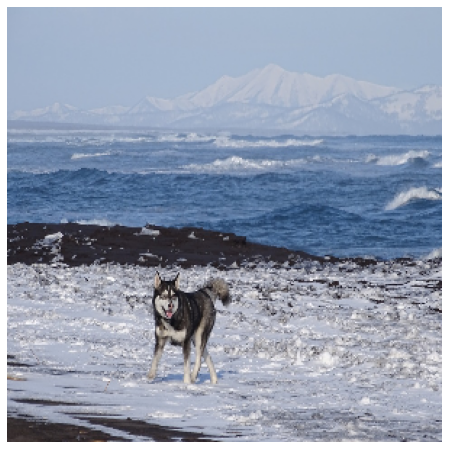

In [84]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()

In [85]:
gradient_color = cv2.applyColorMap(
                  normalized_tensor.numpy(), 
                  cv2.COLORMAP_HOT)


In [87]:
normalized_tensor.shape, gradient_color.shape

(TensorShape([300, 300]), (300, 300, 3))

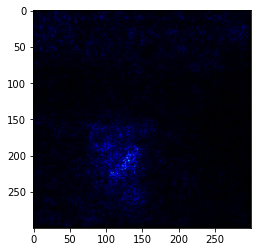

In [88]:
plt.imshow(gradient_color)

In [89]:
gradient_color = gradient_color / 255.0

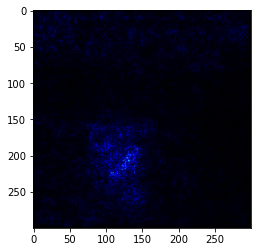

In [90]:
plt.imshow(gradient_color)


In [91]:
super_imposed = cv2.addWeighted(img, 0.4,
                               gradient_color, 0.6, 0.0)

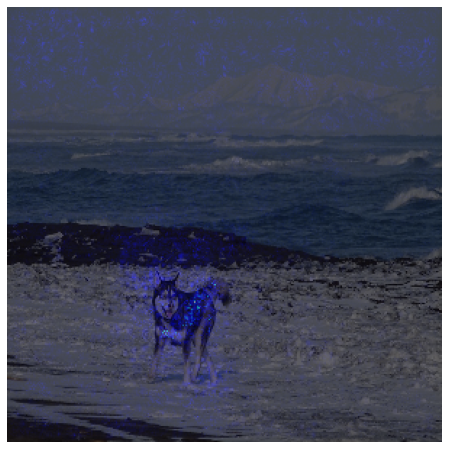

In [92]:
plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()